## 3: Importance sampling for random walks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 3.1 1-D Bernoulli random walk

In [2]:
x = 0.5
N = 100
length = 1
# left or right: 0 or 1

### 2.1 (a) Below:
- define random walk sampler to pass to random walk simulation 

In [3]:
def random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > 0.5] = 1.0
    X[X < 0.5] = -1.0
    return X

In [4]:
def random_walk(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    if cumsum is False:
        estimate =  np.sum(samples, axis=0)
    else:        
        estimate = np.cumsum(samples, axis=0)
        
    return estimate, samples

In [5]:
g = lambda x: x # identity function
num_trials = 500
num_samples = N
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)
#     print("one trial: ", estimator_vals[trial, :])

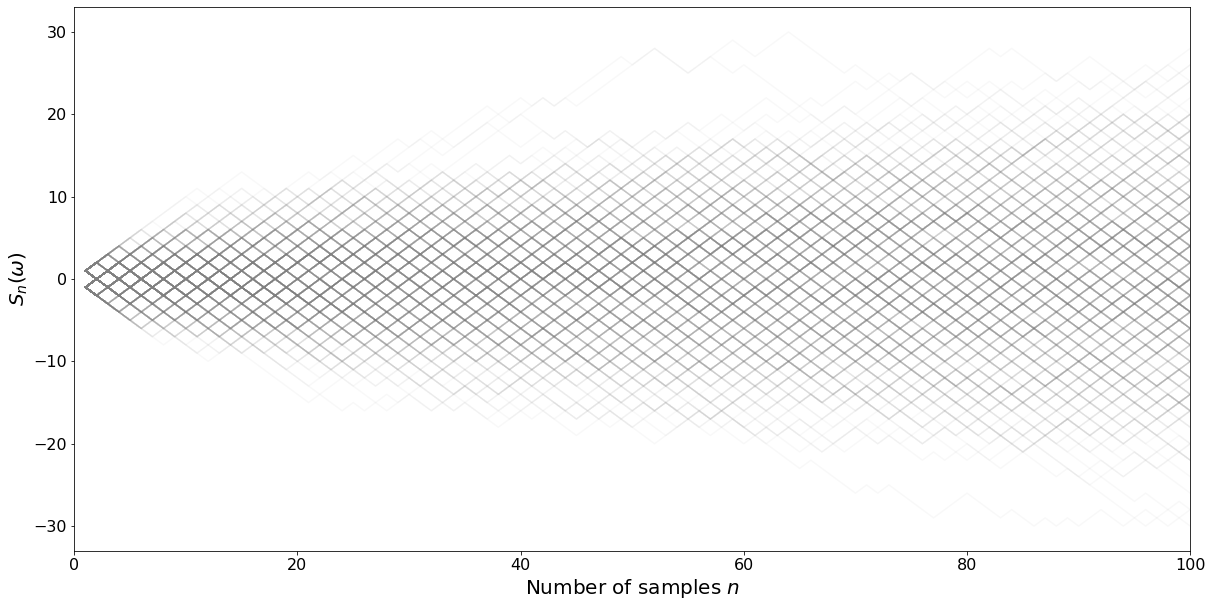

In [6]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+1), estimator_vals.T, color='grey', alpha=0.05)
plt.ylabel(r'$S_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.xlim([0, 100])
# plt.ylim([0, 30])
plt.show()

### 2.1(b) 
- define Monte carlo function below
- then define another function that computes cases when S>10

In [7]:
num_trials = 10**5
def monte_carlo_probability(sample_paths_vs_n, threshold):
    N_paths, _ = sample_paths_vs_n.shape
    s_estimates_satisfy_condition = np.any( sample_paths_vs_n[:,-1:] > threshold, axis = 1 )  # Choose last element which corresponds to N = 100
    s_estimate = np.sum(s_estimates_satisfy_condition) / float(N_paths)
    return s_estimate

In [1]:
estimator_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals[trial, :], _ = random_walk(num_samples, random_walk_sampler, cumsum=True)

threshold = 10
print("P(S>10) = ", monte_carlo_probability(estimator_vals, threshold))

threshold = 55
print("P(S>55) = ", monte_carlo_probability(estimator_vals, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_probability(estimator_vals, threshold))
    
plt.plot(probs)

NameError: name 'np' is not defined

Therefore, probability for steps > about 25 is too low and cannot be computed with standard monte carlo easily. We need importance sampling.

### Actual probability can be calculated as follows:
P(S>10) = 1 - P(S<=10)

Suppose +1 is chosen k times and -1 is chosen 100-k times. Then position at end = $k(1) + (100-k)(-1) = 2k - 100 \leq 10$. Therefore, $k\leq 55$.

$ P(S\leq 55) = \sum_{k=0}^{55} {n \choose k} (0.5)^k (0.5)^{100-k} $

In [5]:
# Actual Probability
from math import factorial
def comb(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

prob = 0
for k in range(56):
    prob = prob + comb(100,k)
print(prob)
prob = prob * 0.5**100
print("Actual P(S>55) = ", 1 - prob)

1.09572357083777e+30
Actual P(S>55) =  0.13562651203691733


### 2.1 (c)
- Importance sampling with $10^5$ trials for P(S>55)
- Next we try importance sampling with a proposal DISCRETE distribution that puts more probability on getting $X_i=1$.

𝜋: P(1) = 0.8, P(-1) = 0.2


This is because, we want to use importance sampling on $X_i$ and therefore the only way we can do this is by shidting probability towards 1.0

In [21]:
shift = 0.1

def shifted_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    X = np.random.rand(num_steps) # samples from a uniform
    # Inverse CDF Trick
    X[X > shift] = 1.0
    X[X < shift] = -1.0
    return X

def prob_normal_walk(sample):
    return 0.5

def prob_shifted_walk(sample):
    if sample>0:
        return 1 - shift
    else:
        return shift

In [22]:
def random_walk_weighted(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    weighted_samples = np.asarray([ sample * prob_normal_walk(sample) / prob_shifted_walk(sample) for sample in samples])
    if cumsum is False:
        estimate =  np.sum(weighted_samples, axis=0)
    else:        
        estimate = np.cumsum(weighted_samples, axis=0)
        
    return estimate, samples

def monte_carlo_importance(sample_paths_vs_n, threshold):
    N_paths, _ = sample_paths_vs_n.shape
    s_estimates_satisfy_condition = np.any( sample_paths_vs_n[:,-1:] > threshold, axis = 1 )  # Choose last element which corresponds to N = 100
    s_estimate = np.sum(s_estimates_satisfy_condition) / float(N_paths)
    return s_estimate

P(S>55) =  6e-05


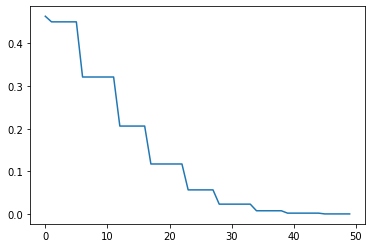

In [23]:
num_trials = 10**5
estimator_vals_importance = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
    estimator_vals_importance[trial, :], _ = random_walk_weighted(num_samples, shifted_random_walk_sampler, cumsum=True)

threshold = 55
print("P(S>55) = ", monte_carlo_importance(estimator_vals_importance, threshold))

probs = []
for threshold in range(50):
    probs.append(monte_carlo_importance(estimator_vals_importance, threshold))
    
plt.plot(probs)

Actual probability can be calculated as follows:
P(S>55) = 1 - P(S<=55)

Suppose +1 is chosen k times and -1 is chosen 100-k times. Then position at end = $k(1) + (100-k)(-1) = 2k - 100 \leq 55$. Therefore, $k\leq 77.5$.

$ P(S\leq 55) = \sum_{k=0}^{77} {n \choose k} (0.5)^k (0.5)^{100-k} $

In [81]:
# Actual Probability
from math import factorial
def comb(n, k):
    return factorial(n) / factorial(k) / factorial(n - k)

prob = 0
for k in range(78):
    prob = prob + comb(100,k)
print(prob)
prob = prob * 0.5**100
print("Actual P(S>55) = ", 1 - prob)

1.26765059014703e+30
Actual P(S>55) =  7.952664082822025e-09


## 2.2 3-D Gaussian Random Walk

2.2(a)

In [126]:
def Gaussian_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    num_dim = 3
    X = np.random.normal(size = (num_dim,num_steps)) # samples from a uniform
    return X

def gaussian_random_walk(num_samples, sample_generator, cumsum=False):

    samples = sample_generator(num_samples)
    if cumsum is False:
        estimate =  np.sum(samples, axis=0)
    else:        
        estimate = np.cumsum(samples, axis=0)
        
    return estimate, samples

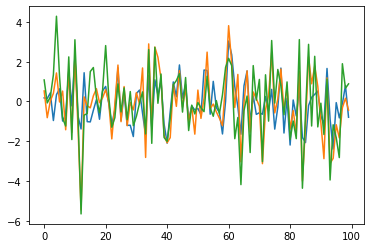

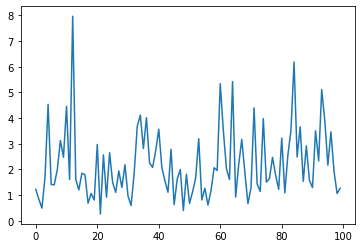

In [168]:
N = 100
path, samples = gaussian_random_walk(N, Gaussian_random_walk_sampler, cumsum = True)

plt.figure()
plt.plot(path[0,:], label = r'x_1')
plt.plot(path[1,:], label = r'x_2')
plt.plot(path[2,:], label = r'x_3')

plt.figure()
plt.plot(np.linalg.norm(path, axis=0))

2.2(b)

In [185]:
num_trials = 10**5
num_samples = N
estimator_gaussian_vals = np.zeros((num_trials, num_samples))
for trial in range(num_trials):
        path, _  = gaussian_random_walk(num_samples, Gaussian_random_walk_sampler, cumsum=True)
#         print("path shape", path.shape)
#         print("|S| shape", np.linalg.norm(path, axis=0).shape)
        estimator_gaussian_vals[trial, :] = np.linalg.norm(path, axis=0)
print(estimator_gaussian_vals.shape )

(100000, 100)


In [181]:
threshold = 10
print("P(|S|>10) = ", monte_carlo_probability(estimator_gaussian_vals, threshold))

P(|S|>10) =  1e-05


Note here that the above probability varianec is very high even with num_trials = $10^5$. Most of the times, the probability will come out to be 0. Other times it is $10^{-5}$

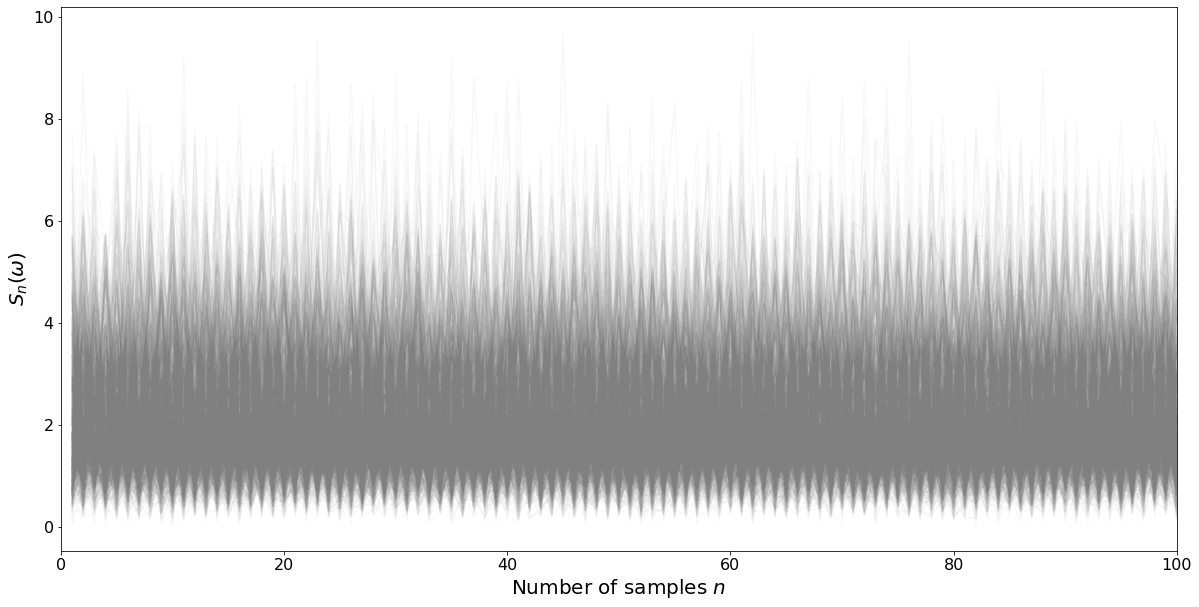

In [159]:
# plt.figure(figsize=(20,10))
# plt.plot(np.arange(1, num_samples+1), estimator_gaussian_vals.T, color='grey', alpha=0.05)
# plt.ylabel(r'$S_n(\omega)$', fontsize=20)
# plt.xlabel(r'Number of samples $n$', fontsize=20)
# plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# plt.yticks(fontsize=16)
# plt.xlim([0, 100])
# # plt.ylim([0, 30])
# plt.show()

2.2 (c)

In [184]:
def shifted_Gaussian_random_walk_sampler(num_steps):
    """ Generate a set of steps for a random walk"""
    num_dim = 3
    X = np.random.normal(loc = (55/100.0/np.sqrt(3)), size = (num_dim,num_steps)) # samples from a uniform
    return X